In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


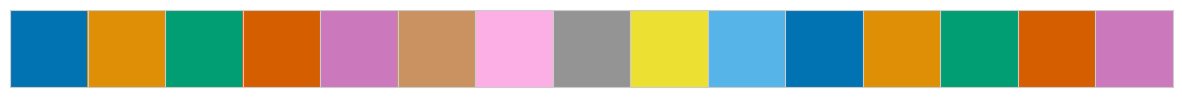

In [18]:
import sys
sys.path.insert(0, '..//src/')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import main
from common import enums, functions, schema
import geopandas as gpd
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

In [19]:
PATH_ORG = main.PATH_ORG
PATH_TABLES = PATH_ORG / r"General/communication/tables"
PATH_SAVE_FIGURES = PATH_ORG / r"General/communication/figures"

## PV generation using PVlib

In [ ]:
import pvlib
from dataclasses import dataclass
from pvlib import location
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

geolocation = {"Birmingham": (52.489471,-1.898575),
"Cardiff": (51.481583,-3.179090),
"Edinburgh": (55.953251-3.188267),
"Glasgow": (55.860916,-4.251433),
"Leeds": (53.801277,-1.548567),
"Manchester" : (53.483959, -2.244644)}

@dataclass
class PVmodel:
  city_name: str
  irradiance_data: pd.DataFrame
  azimuth: int = 180
  slope: int = 30

  @property
  def location(self) -> pvlib.location.Location:
    if self.irradiance_data.index.tz is None:
      self.irradiance_data.index = self.irradiance_data.index.tz_localize(
          'Europe/London')
      print(self.irradiance_data.index.tz)
    return pvlib.location.Location(geolocation[self.city_name][0],
                                   geolocation[self.city_name][1],
                                   tz=self.irradiance_data.index.tz)

  def add_solar_components_to_ghi_data(self) -> pd.DataFrame:
    ghi_data = self.irradiance_data.copy()
    ghi_data.columns = ['ghi']
    # Calculate solar position for each timestamp in weather_data data
    solar_position: pd.DataFrame = self.location.get_solarposition(
        ghi_data.index)
    dni_data: pd.DataFrame = pvlib.irradiance.disc(
        ghi_data['ghi'].values,
        solar_zenith=solar_position['zenith'],
        datetime_or_doy=ghi_data.index)
    weather_data: pd.DataFrame = pd.concat([dni_data, ghi_data], axis=1)
    # weather_data = pd.concat([weather_data, temperature_data], axis=1)
    weather_data['dhi'] = (
        weather_data['ghi'] -
        np.cos(solar_position['zenith'] * np.pi / 180) * weather_data['dni']
    )  # GHI = DNI*cosθ + DHI
    return self.convert_to_poa(weather_data)

  def convert_to_poa(self, dataf: pd.DataFrame) -> pd.DataFrame:
    """Convert a dataframe with dni, ghi, dhi, apparent_zenith, azimuth and airmass_relative to poa"""

    # Calculate solar position for each timestamp in weather_data data
    solar_position = self.location.get_solarposition(dataf.index)

    # Calculate airmass for each timestamp in weather_data data
    airmass = self.location.get_airmass(dataf.index)

    # Calculate POA irradiance for each timestamp in weather_data data
    dataf = pvlib.irradiance.get_total_irradiance(
        surface_tilt=0,
        surface_azimuth=180,
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni=dataf['dni'],
        ghi=dataf['ghi'],
        dhi=dataf['dhi'],
        airmass=airmass['airmass_relative'])
    return dataf

  def get_pv_generation(self):

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm'][
        'open_rack_glass_glass']
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    print(sandia_module)
    cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    location = self.location

    system = PVSystem(
        surface_tilt=self.slope,
        surface_azimuth=self.azimuth,
        module_parameters=sandia_module,
        inverter_parameters=cec_inverter,
        temperature_model_parameters=temperature_model_parameters)

    mc = ModelChain(system, location)
    mc.run_model_from_poa(self.add_solar_components_to_ghi_data())
    kWp_pv = (sandia_module.Impo * sandia_module.Vmpo) / 1000
  
    return mc.results.ac / 1000 / kWp_pv  #kWh/kWp

## PVlib data UKPN network

In [21]:
weather_path = Path(r'/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/National Grid - Open Innovation - Documents/General/02 - Work/00 - Misc and data/data/CIBSE weather data/input_model')

In [22]:
city = "Birmingham"
column_names = [
  'Year', 'Month', 'Day', 'Hour', 'PWC', 'Cloud', 'DBT', 'WBT', 'RH', 'Press', 'WD', 'WS', 'GSR', 'DSR', 'Alt', 'Dec', 'Cloud1', 'DBT1', 'WBT1', 'Press1', 'WD1', 'WS1'
]
pathlist = weather_path.rglob('*_DSY2_2050High50*.csv')

dict_cibse_temperature: dict[str, pd.Series] = {}
for path in pathlist:
  print(path.stem)
  if city in path.stem:
    la_str = path.stem.split('_DSY2_2050High50')[0]
    temp_dataf = pd.read_csv(path,
                             skiprows=32,
                             header=None,
                             delimiter=",",
                             names=column_names)
    weather_data = functions.format_weather_data(temp_dataf)

power_output_data = []

for azimuth in (180+45, 180, 180-45):
  pv_model = PVmodel(
      city, weather_data[schema.DataSchema.SOLARRADIATION].to_frame(), azimuth=azimuth)
  pv_generation = pv_model.get_pv_generation()
  dataf = pv_generation.to_frame()
  new_name_col = f'P_{azimuth}_(kW)'
  dataf.columns = [new_name_col]
  power_output_data.append(dataf[new_name_col])

pv_outputs_df = pd.concat(power_output_data, axis=1)
pv_outputs_df['P_mean'] = pv_outputs_df.mean(axis=1)
pv_outputs_df.head()

Edinburgh_DSY2_2050High50_
Leeds_DSY2_2050High50_
Belfast_DSY2_2050High50_
Glasgow_DSY2_2050High50_
Cardiff_DSY2_2050High50_
Birmingham_DSY2_2050High50_
Manchester_DSY2_2050High50_
London_LWC_DSY2_2050High50
London_LHR_DSY2_2050High50
London_GTW_DSY2_2050High50
Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                  

,P_225_(kW),P_180_(kW),P_135_(kW),P_mean
index,,,,
2050-05-01 00:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 01:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 02:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 03:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 04:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341


,Solar_radiation(W/m2)
index,
2050-05-01 00:00:00+00:00,0
2050-05-01 01:00:00+00:00,0
2050-05-01 02:00:00+00:00,0
2050-05-01 03:00:00+00:00,0
2050-05-01 04:00:00+00:00,0
...,...
2050-09-30 19:00:00+00:00,0
2050-09-30 20:00:00+00:00,0
2050-09-30 21:00:00+00:00,0


In [33]:
pv_outputs_df

,P_225_(kW),P_180_(kW),P_135_(kW),P_mean
index,,,,
2050-05-01 00:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 01:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 02:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 03:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 04:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
...,...,...,...,...
2050-09-30 19:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-09-30 20:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-09-30 21:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341


In [38]:
weather_filt

,Solar_radiation(W/m2),Outdoor_air_temperature_(degreeC)
index,,
2050-05-01 05:00:00,2,9.5
2050-05-01 06:00:00,42,9.7
2050-05-01 07:00:00,55,10.8
2050-05-01 08:00:00,89,11.2
2050-05-01 09:00:00,275,11.9
...,...,...
2050-09-30 14:00:00,426,19.3
2050-09-30 15:00:00,293,19.9
2050-09-30 16:00:00,264,19.3


In [47]:
filt = pv_model.irradiance_data['Solar_radiation(W/m2)'] > 0
weather_filt = pv_model.irradiance_data[filt].copy()
kWp = 4.54629*48.3156
pv_outputs_filt = pv_outputs_df.loc[weather_filt.index, :].copy()*kWp

weather_filt

,Solar_radiation(W/m2)
index,
2050-05-01 05:00:00+00:00,2
2050-05-01 06:00:00+00:00,42
2050-05-01 07:00:00+00:00,55
2050-05-01 08:00:00+00:00,89
2050-05-01 09:00:00+00:00,275
...,...
2050-09-30 14:00:00+00:00,426
2050-09-30 15:00:00+00:00,293
2050-09-30 16:00:00+00:00,264


In [49]:
(pv_outputs_filt['P_mean']/(weather_filt['Solar_radiation(W/m2)'])).mean()

np.float64(0.14325571702531262)

array([-inf, -inf, -inf, ..., -inf, -inf, -inf], shape=(3672,))

In [ ]:
pv_outputs_df.sum()

P_225_(kW)    570.729614
P_180_(kW)    564.335343
P_135_(kW)    531.609006
P_mean        555.557987
dtype: float64

Text(0.5, 0, '')

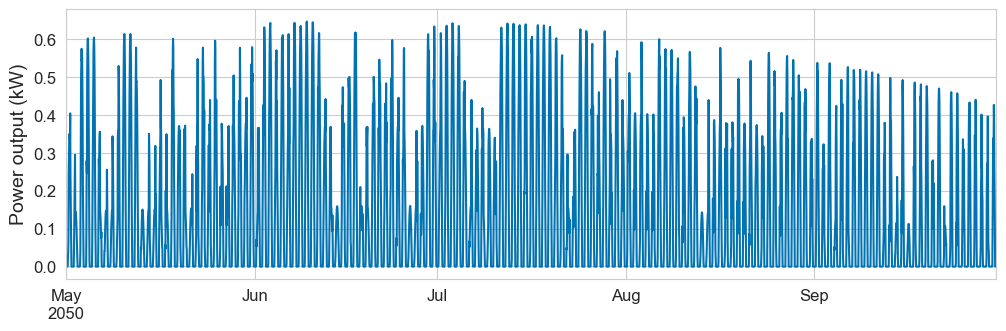

In [42]:
fig, ax = plt.subplots(figsize=figsize)
pv_outputs_df['P_mean'].plot(ax=ax)
ax.set_ylabel('Power output (kW)')
ax.set_xlabel('')

### UKPN DFES DATA AT LSOA LEVEL FOR 2050

In [30]:
PATH_ORG = main.PATH_ORG
ukpn_dfes_path = PATH_ORG / r'General/data/Electricity substation data/ukpn'

fn = "DFES-2022--Leading_the_Way--Domestic-PV-capacity--LSOA.csv"
dfes_dataf = pd.read_csv(ukpn_dfes_path / fn, index_col=0)
dfes_dataf.head()

,LSOAs,2021 (kW),2022 (kW),2023 (kW),2024 (kW),2025 (kW),2026 (kW),2027 (kW),2028 (kW),2029 (kW),...,2041 (kW),2042 (kW),2043 (kW),2044 (kW),2045 (kW),2046 (kW),2047 (kW),2048 (kW),2049 (kW),2050 (kW)
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01000001,City of London 001A,0,0,0,0,0,0,0,0,0,...,2,2,2,3,3,3,3,3,4,4
E01000002,City of London 001B,22,26,28,31,34,34,34,35,35,...,42,43,44,45,45,46,47,48,48,49
E01000003,City of London 001C,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
E01000005,City of London 001E,3,4,4,4,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
E01000006,Barking and Dagenham 016A,12,14,15,17,18,20,21,23,25,...,57,60,64,68,71,75,79,82,85,87


In [31]:
list_lsoas = dfes_dataf.index.unique()
len(list_lsoas)

10639

## Extract cooling demand of LSOAs in ukpn

In [32]:
residential_data = main.import_thermal_characteristics_data(
    main.PATH_GB_DATA / 'Thermal_characteristics_afterEE.csv', 2020, 2050)
filt = residential_data['LSOA_code'].isin(list_lsoas)
residential_data = residential_data[filt]
residential_data = residential_data.reset_index()
list_la_code = list(residential_data['ladcd'].unique())
residential_data.head()

,Index,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm
0,62870,E01000001,City of London,London,flat,oil boiler,8279.798083,0.190661,14,8115.289346,82.797981,low,-2,Birmingham,E09000001,city of london
1,62871,E01000001,City of London,London,semi-detached,gas boiler,9795.057610,0.262593,2,11176.994057,97.950576,low,-2,Birmingham,E09000001,city of london
2,62872,E01000001,City of London,London,terraced,gas boiler,18601.417481,0.467660,1,19905.482816,186.014175,low,-2,Birmingham,E09000001,city of london
3,62873,E01000001,City of London,London,terraced,resistance heating,6526.000000,0.062456,11,2658.375704,65.260000,low,-2,Birmingham,E09000001,city of london
4,62874,E01000001,City of London,London,flat,gas boiler,5785.363636,0.114664,107,4880.555556,57.853636,low,-2,Birmingham,E09000001,city of london


In [33]:
import icecream as ic

PATH_RESULTS =PATH_ORG / r'General/04 - Analysis/2050 high emission'

# PATH_RESULTS = Path(r'C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/city of london_E09000001/')

try:
  ukpn_lsoa_cooling_demand = pd.read_csv(ukpn_dfes_path /
                                         "ukpn_lsoa_cooling_demand.csv",
                                         index_col=0, parse_dates=True)
except:

  pathlist = (Path(PATH_RESULTS)/'simulation').rglob('*_total_heating_outputs.csv')


  lsoa_to_index_dict = dict(residential_data.groupby('LSOA_code')['Index'].apply(list))

  frames:dict[str, pd.Series] = {}
  for temp_path in pathlist:
    ic.ic(temp_path)
    la_str = temp_path.stem.split('_total_heating_outputs')[0]
    la_code = la_str.split('_')[-1]
    ic.ic(la_code)
    if la_code in list_la_code:
      temp_sim_results = pd.read_csv(temp_path, index_col=0, parse_dates=True)
      temp_sim_results.columns = [int(x) for x in temp_sim_results.columns]
      for lsoa_code, list_index in lsoa_to_index_dict.items():
        list_index_in_file = [
            x for x in temp_sim_results.columns if x in list_index
        ]
        if len(list_index_in_file) > 0:
          ic.ic(lsoa_code)
          frames[lsoa_code] = -temp_sim_results[list_index].sum(axis=1)

  ukpn_lsoa_cooling_demand = pd.concat(frames, axis=1)
  ukpn_lsoa_cooling_demand.to_csv(ukpn_dfes_path /
                                  "ukpn_lsoa_cooling_demand.csv")

In [34]:
pv_outputs_df.index = ukpn_lsoa_cooling_demand.index

In [35]:
target_year = 2050
filt = dfes_dataf.index.isin(ukpn_lsoa_cooling_demand.columns)
total_capacity_installed = dfes_dataf.loc[filt, f'{target_year} (kW)'].sum()
total_pv_generation = pv_outputs_df[
    'P_mean'] * total_capacity_installed / 1000000 # from kWh to GWh
total_pv_generation = total_pv_generation.to_frame()
total_pv_generation.columns = ['PV_output']

In [36]:
total_pv_generation.sum()

PV_output    1891.0855
dtype: float64

## UKPN results for the entire area

In [37]:
scop=14/3.412 #https://www.eia.gov/todayinenergy/detail.php?id=40232
cop = scop*0.875
total_cooling_demand = ukpn_lsoa_cooling_demand.sum(
    axis=1).to_frame() / 1000000 / cop  # in GWh

total_cooling_demand.columns = ['Electricity_for_cooling_demand']
total_data = pd.concat([total_pv_generation, total_cooling_demand], axis=1)
total_data.head()

,PV_output,Electricity_for_cooling_demand
Time_(h),,
2050-05-01 00:00:00,-0.001162,0.0
2050-05-01 01:00:00,-0.001162,0.0
2050-05-01 02:00:00,-0.001162,0.0
2050-05-01 03:00:00,-0.001162,0.0
2050-05-01 04:00:00,-0.001162,0.0


In [38]:
normalised_data = total_data/total_data.max()
total_data.sum()

PV_output                         1891.08550
Electricity_for_cooling_demand    3664.76407
dtype: float64

In [39]:
normalised_data

,PV_output,Electricity_for_cooling_demand
Time_(h),,
2050-05-01 00:00:00,-0.000528,0.0
2050-05-01 01:00:00,-0.000528,0.0
2050-05-01 02:00:00,-0.000528,0.0
2050-05-01 03:00:00,-0.000528,0.0
2050-05-01 04:00:00,-0.000528,0.0
...,...,...
2050-09-30 19:00:00,-0.000528,0.0
2050-09-30 20:00:00,-0.000528,0.0
2050-09-30 21:00:00,-0.000528,0.0


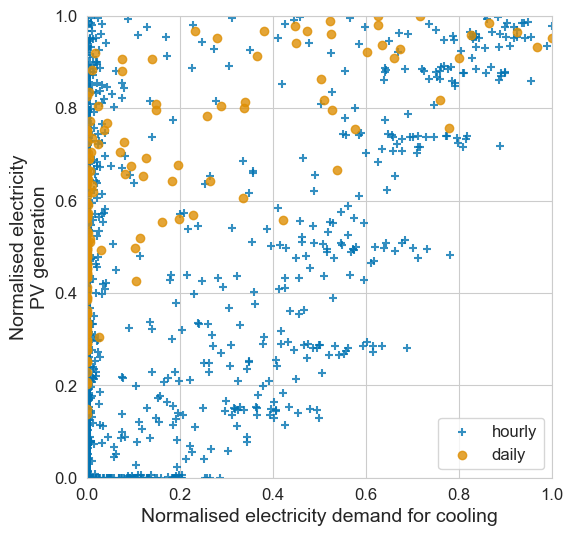

In [40]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=normalised_data, x='Electricity_for_cooling_demand', y="PV_output", ax=ax, label="hourly", marker='+', fit_reg=False)
daily_data = normalised_data.resample('1d').mean()
# ax.scatter(x=daily_data['Electricity_for_cooling_demand'],
#            y=daily_data["PV_output"])
sns.regplot(data=daily_data/daily_data.max(), x='Electricity_for_cooling_demand', y="PV_output", ax=ax, label="daily", fit_reg=False)
ax.set_xlabel("Normalised electricity demand for cooling")
ax.set_ylabel("Normalised electricity\nPV generation")
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.legend()

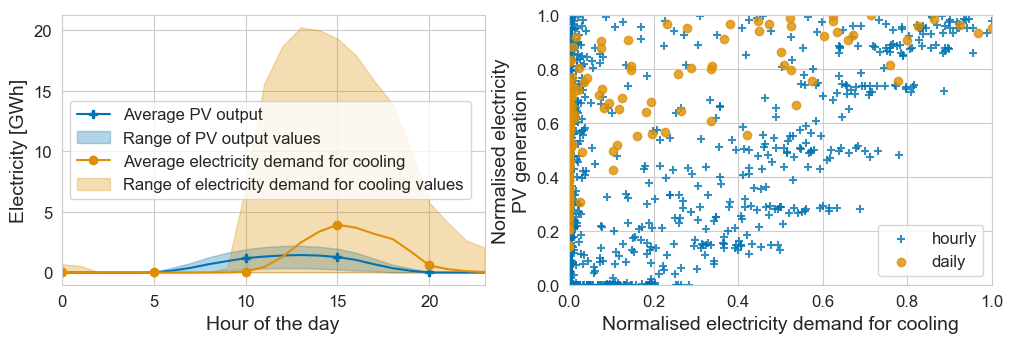

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
# Plot 1
average_week_day = total_data.groupby([total_data.index.hour]).mean().reset_index(drop=True)
max_week_day = total_data.groupby([total_data.index.hour]).max().reset_index(drop=True)
min_week_day = total_data.groupby([total_data.index.hour]).min().reset_index(drop=True)
labels = ['Average PV output', 'Average electricity demand for cooling']
labels_shaded = ['Range of PV output values', 'Range of electricity demand for cooling values']
for ii, c in enumerate(average_week_day.columns):
  average_week_day[c].plot(
        ax=ax1,
        kind='line',
        marker=markers[ii],    markevery=5, label=labels[ii])
  ax1.fill_between(average_week_day.index, min_week_day[c],max_week_day[c], color = sns.color_palette()[ii], alpha=0.3, label=labels_shaded[ii])

ax1.set_ylabel('Electricity [GWh]')
ax1.set_xlabel('Hour of the day')
ax1.margins(0, None)
ax1.legend(loc='center left')
# ax1.legend(bbox_to_anchor=(0.98, -0.12), ncol=4, borderaxespad=0.)

# Plot 2
sns.regplot(data=normalised_data, x='Electricity_for_cooling_demand', y="PV_output", ax=ax2, label="hourly", marker='+', fit_reg=False)
daily_data = normalised_data.resample('1d').mean()
# ax.scatter(x=daily_data['Electricity_for_cooling_demand'],
#            y=daily_data["PV_output"])
sns.regplot(data=daily_data/daily_data.max(), x='Electricity_for_cooling_demand', y="PV_output", ax=ax2, label="daily", fit_reg=False)
ax2.set_xlabel("Normalised electricity demand for cooling")
ax2.set_ylabel("Normalised electricity\nPV generation")
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 1)
ax2.legend()
fig.savefig(PATH_SAVE_FIGURES/f"ukpn_pv_and_cooling.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"ukpn_pv_and_cooling.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

In [20]:
total_data['Net_electricity_for_cooling_demand'] = total_data['Electricity_for_cooling_demand'] - total_data['PV_output']
average_week_day = total_data.groupby([total_data.index.hour]).mean().reset_index(drop=True)
average_week_day.max()

PV_output                             1.440081
Electricity_for_cooling_demand        3.944412
Net_electricity_for_cooling_demand    2.668548
dtype: float64

In [21]:
(2.667514-3.944412)/3.944412

-0.32372328245629506

In [22]:
## Calculate the net-demand as the difference between the cooling demand and the pv generation
target_year = 2050
frames_net_demand = {}
for lsoa_code in ukpn_lsoa_cooling_demand.columns:
  pv_capacity_installed = dfes_dataf.loc[lsoa_code, f'{target_year} (kW)']
  ic.ic(lsoa_code, pv_capacity_installed)
  pv_generation = pv_outputs_df['P_mean'] * pv_capacity_installed
  frames_net_demand[lsoa_code] = (ukpn_lsoa_cooling_demand[lsoa_code]/cop -
                                  pv_generation)
net_demand_df = pd.concat(frames_net_demand, axis=1)

ic| lsoa_code: 'E01031338', pv_capacity_installed: np.int64(150)
ic| lsoa_code: 'E01031339', pv_capacity_installed: np.int64(399)
ic| lsoa_code: 'E01031340', pv_capacity_installed: np.int64(412)
ic| lsoa_code: 'E01031341', pv_capacity_installed: np.int64(317)
ic| lsoa_code: 'E01031342', pv_capacity_installed: np.int64(392)
ic| lsoa_code: 'E01031343', pv_capacity_installed: np.int64(303)
ic| lsoa_code: 'E01031344', pv_capacity_installed: np.int64(484)
ic| lsoa_code: 'E01031345', pv_capacity_installed: np.int64(365)
ic| lsoa_code: 'E01031346', pv_capacity_installed: np.int64(406)
ic| lsoa_code: 'E01031347', pv_capacity_installed: np.int64(274)
ic| lsoa_code: 'E01031348', pv_capacity_installed: np.int64(315)
ic| lsoa_code: 'E01031349', pv_capacity_installed: np.int64(253)
ic| lsoa_code: 'E01031350', pv_capacity_installed: np.int64(340)
ic| lsoa_code: 'E01031351', pv_capacity_installed: np.int64(715)
ic| lsoa_code: 'E01031352', pv_capacity_installed: np.int64(192)
ic| lsoa_code: 'E01031353

KeyboardInterrupt: 

In [ ]:
max_headroom = ukpn_lsoa_cooling_demand.max()/cop/1000
max_headroom = max_headroom.reset_index()
max_headroom.columns = ["LSOA", "Peak demand (GW)"]
max_headroom['Name'] = "Peak - Electricity for cooling demand"

q95_headroom = ukpn_lsoa_cooling_demand.quantile(0.95)/cop/1000
q95_headroom = q95_headroom.reset_index()
q95_headroom.columns = ["LSOA", "Peak demand (GW)"]
q95_headroom['Name'] = "95% percentiles - Electricity for cooling demand"
q95_headroom.head()

In [116]:
net_max_headroom = (net_demand_df.max()/1000).reset_index()
net_max_headroom.columns = ["LSOA", "Peak demand (GW)"]
net_max_headroom['Name'] = "Peak - Net electricity for cooling demand"

net_q95_headroom = (net_demand_df.quantile(0.95)/1000).reset_index()
net_q95_headroom.columns = ["LSOA", "Peak demand (GW)"]
net_q95_headroom['Name'] = "95% percentiles - Net electricity for cooling demand"

additional_headroom = pd.concat([max_headroom, q95_headroom, net_max_headroom, net_q95_headroom])

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(
    additional_headroom, x="Peak demand (GW)",  y='Name',
    whis=[0, 100], width=.6
)
# sns.palplot(sns.color_palette())
ax.set_ylabel('')
ax.set_xlabel('Additional capacity (GW)')

fig.savefig(PATH_SAVE_FIGURES/f"additiona_capacity.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"additiona_capacity.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig

In [ ]:
pd.pivot_table(additional_headroom, values='Peak demand (GW)', columns='Name', index='LSOA').describe()

In [ ]:
0.731268/1.587675

In [ ]:
(1.587675-1.784885)/1.784885

In [ ]:
0.822456/1.784885

In [122]:
net_demand_df = net_demand_df.max().reset_index()
net_demand_df.columns = ["LSOA", "Peak demand (MW)"]
net_demand_df['Name'] = "Cooling demand\nminus PV generation"

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
peak_demand = ukpn_lsoa_cooling_demand.max()/scop
peak_demand = peak_demand.reset_index()
peak_demand.columns = ["LSOA", "Peak demand (MW)"]
peak_demand['Name'] = "Cooling demand"
peak_demand = pd.concat([peak_demand, net_demand_df])
peak_demand["Peak demand (MW)"] = peak_demand["Peak demand (MW)"]/1000
# # Plot the orbital period with horizontal boxes
sns.boxplot(
    peak_demand, x='Name',  y="Peak demand (MW)",
    whis=[0, 100], width=.6, palette="vlag"
)

# # Add in points to show each observation
# sns.stripplot(planets, x="distance", y="method", size=4, color=".3")

In [ ]:
net_demand_df.head()

In [ ]:
lsoa_code

In [126]:
def plot_map(map_df,
             target,
             ax,
             vmin=None,
             vmax=None,
             cmap=None,
             legend=False, label_legend:str=''):

  # map_df = map_df.dropna(subset=[target])
  # create figure and axes for Matplotlib
  if vmin is None:
    if map_df[target].min() < 0:
      vmin = map_df[target].min()
    else:
      vmin = 0
  if vmax is None:
    vmax = map_df[target].max()

  if cmap == None:
    cmap = 'Blues'

  ax.axis('off')
  ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

  map_df = map_df.to_crs(epsg=3395)  # mercator projections

  if legend:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    map = map_df.plot(column=target,
                      cmap=cmap,
                      linewidth=0.01,
                      ax=ax,
                      edgecolor='black',
                      vmin=vmin,
                      vmax=vmax,
                      legend=legend,
                      legend_kwds={
                          "label": label_legend,
                          "orientation": "horizontal"
                      },
                      cax=cax)
  else:
    map = map_df.plot(column=target,
                      cmap=cmap,
                      linewidth=0.01,
                      ax=ax,
                      edgecolor='black',
                      vmin=vmin,
                      vmax=vmax)
  plt.close()
  return map


In [ ]:
path_map =  PATH_ORG / r'General/resources/maps/'
file = "UK_2011_Census_boundaries_LSOA_fixed.geojson"
path_map = path_map/file
map_df = gpd.read_file(path_map)
filt = map_df['GeographyCode'].isin(dfes_dataf.index)
map_df.head()

#### PV capacity installed at LSOA level

In [ ]:
target_year = 2050
pv_installed_capacity_2050 = dfes_dataf.loc[:, f'{target_year} (kW)'].to_frame()
pv_installed_capacity_2050.columns = ["PV capacity installed (kW)"]
pv_installed_capacity_2050.head()

In [ ]:
pv_installed_capacity_2050.sum()/1000000

In [130]:
map_df = pd.merge(map_df, pv_installed_capacity_2050, left_on='GeographyCode', right_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(figsize_map))
cmap_1 = "YlGnBu"
target = "PV capacity installed (kW)"
plot_map(map_df, target, ax, cmap=cmap_1, legend=True, label_legend="PV capacity installed (kW)")
# ax.set_title('Headroom demand in 2050 excl. cooling demand')

fig.savefig(PATH_SAVE_FIGURES/f"ukpn_lsoa_pv_capacity.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"ukpn_lsoa_pv_capacity.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig

#### Cooling demand at LSOA level

In [132]:
cooling_demand = ukpn_lsoa_cooling_demand.sum().to_frame()/1000000/cop
cooling_demand.columns = ['Electricity for cooling (GWh)']

In [133]:
filt = map_df['GeographyCode'].isin(cooling_demand.index)
map_df = map_df[filt]
map_df = pd.merge(map_df, cooling_demand, left_on='GeographyCode', right_index=True)

In [ ]:
cooling_demand.sum()

In [ ]:
fig, ax = plt.subplots(figsize=(figsize_map))
cmap_1 = "YlGnBu"
target = 'Electricity for cooling (GWh)'
plot_map(map_df, target, ax, cmap=cmap_1, legend=True, label_legend='Electricity for cooling (GWh)')
# ax.set_title('Headroom demand in 2050 excl. cooling demand')

fig.savefig(PATH_SAVE_FIGURES/f"ukpn_lsoa_electricity_for_cooling.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"ukpn_lsoa_electricity_for_cooling.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig